In [1]:
import os
import sys
scripts_dir = os.path.abspath(os.path.join(os.pardir, "scripts"))
sys.path.append(scripts_dir)
import density_ratio_estimators as dre
import numpy as np
import pandas as pd
import scipy.stats as st
from concurrent.futures import ProcessPoolExecutor, as_completed
from multiprocessing import get_context
from plotnine import *

In [5]:
def help_do_1_run(numer_class, numer_params, denom_class, denom_params, rng):
    numer_params = numer_params.copy()
    x_numer = numer_class.rvs(**numer_params, random_state=rng)
    size_numer = numer_params.pop("size")
    denom_params = denom_params.copy()
    x_denom = denom_class.rvs(**denom_params, random_state=rng)
    size_denom = denom_params.pop("size")

    x = np.concatenate((x_numer, x_denom))
    f_numer = numer_class.pdf(x, **numer_params)
    f_denom = denom_class.pdf(x, **denom_params)
    r = f_numer / f_denom
    df = pd.DataFrame({"sample_type": np.repeat(["numer", "denom"], [size_numer, size_denom]), "x": x, "r": r})
    return df

def do_1_run(numer_class, numer_params, denom_class, denom_params, estimator_class, estimator_init_args, rng=None):
    df = pd.concat([help_do_1_run(numer_class, numer_params, denom_class, denom_params, rng) for _ in range(2)])
    df.insert(0, "dataset_type", np.repeat(["train", "test"], len(df) // 2))

    df_train = df[df["dataset_type"] == "train"]
    df_test = df[df["dataset_type"] == "test"]

    x_train = df_train["x"].to_numpy().reshape(-1, 1)
    x_train_numer = x_train[df_train["sample_type"] == "numer"]
    x_train_denom = x_train[df_train["sample_type"] == "denom"]
    x_test = df_test["x"].to_numpy().reshape(-1, 1)

    estimator = estimator_class(**estimator_init_args)
    estimator.fit(x_train_numer, x_train_denom)
    r_hat_train = estimator.predict(x_train)
    r_hat_test = estimator.predict(x_test)
    df["r_hat"] = np.concatenate([r_hat_train, r_hat_test])
    df["squared_err"] = (df["r_hat"] - df["r"]) ** 2
    df["rel_err"] = (df["r_hat"] - df["r"]) / df["r"]

    rmse_train = df[df["dataset_type"] == "train"]["squared_err"].mean() ** 0.5
    rmse_test = df[df["dataset_type"] == "test"]["squared_err"].mean() ** 0.5

    return df, rmse_train, rmse_test

def plot_1_run_results(df, rmse_train, rmse_test):
    df = df.copy()
    train_str = f"Training Set (RMSE = {rmse_train:.2f})"
    test_str = f"Test Set (RMSE = {rmse_test:.2f})"
    df["dataset_type"] = np.where(df["dataset_type"] == "train", train_str, test_str)
    plot = (
        ggplot(data=df, mapping=aes(x="x"))
        + facet_wrap("dataset_type")
        + geom_line(mapping=aes(y="r"))
        + geom_line(mapping=aes(y="r_hat"), color="red")
        + labs(y="True or Estimated Ratio", caption="Black line: true ratios, red line: estimates")
        + theme_bw()
    )
    return plot

def simulate(num_runs, max_workers, numer_class, numer_params, denom_class, denom_params, estimator_class, estimator_init_args):
    rng = np.random.default_rng()
    child_rngs = rng.spawn(num_runs)
    rmses = []
    with ProcessPoolExecutor(max_workers, mp_context=get_context("fork")) as executor:
        futures = [
            executor.submit(
                do_1_run, numer_class, numer_params, denom_class, denom_params, estimator_class, estimator_init_args, child_rngs[i]
            )
            for i in range(num_runs)
        ]
        for future in as_completed(futures):
            try:
                _, rmse_train, rmse_test = future.result()
                rmses.append({"rmse_train": rmse_train, "rmse_test": rmse_test})
            except Exception as e:
                print(f"Run failed: {e}")
                rmses.append({"rmse_train": np.nan, "rmse_test": np.nan})
    return pd.DataFrame(rmses)

In [11]:
df, rmse_train, rmse_test = do_1_run(
    numer_class=st.norm,
    numer_params={"size": 10000},
    denom_class=st.norm,
    denom_params={"size": 10000},
    estimator_class=dre.KNNDensityRatioEstimator,
    estimator_init_args={"k_numer": 5000, "k_denom": 5000}
)

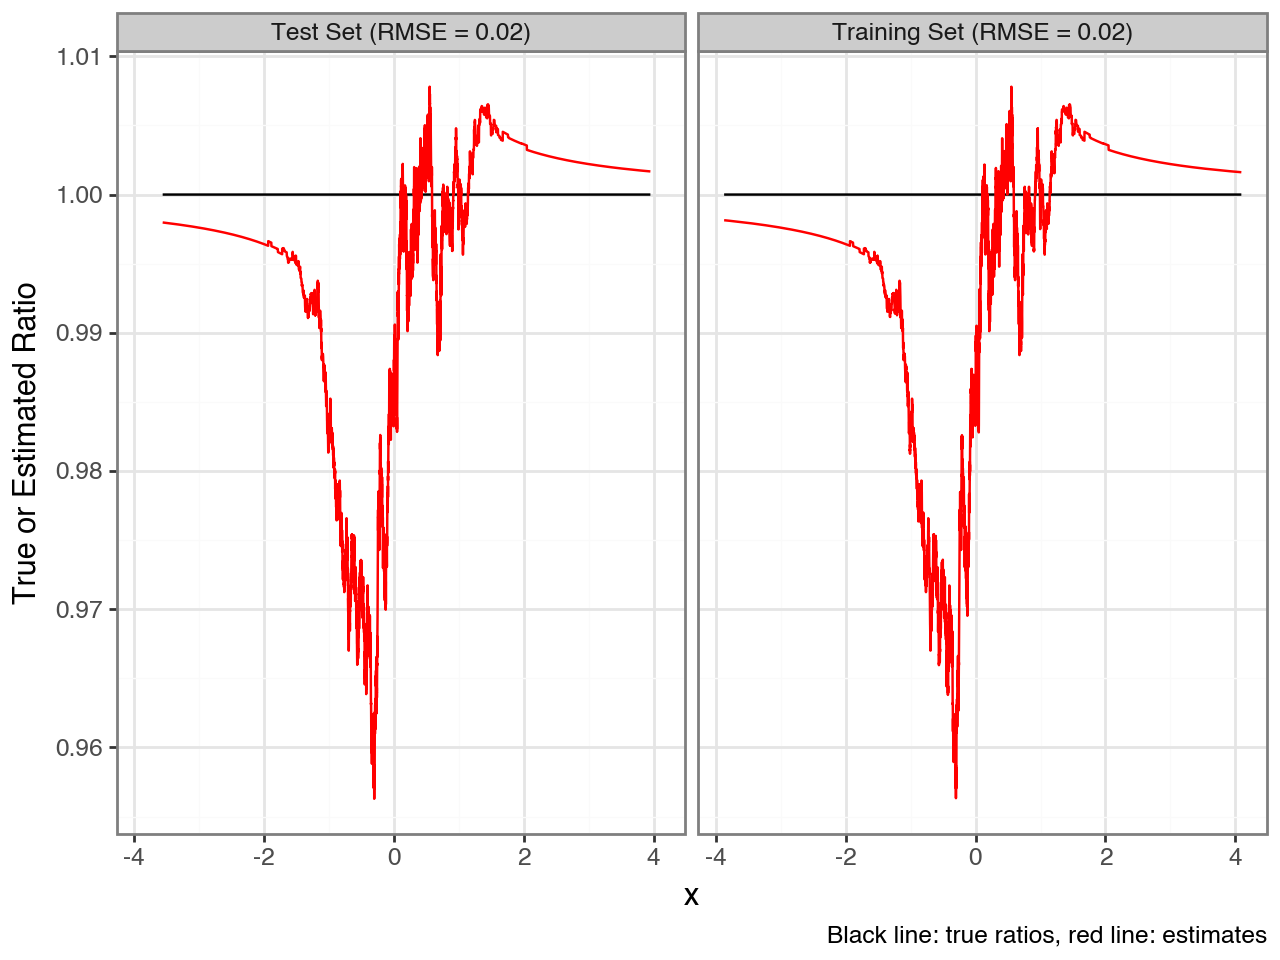

In [12]:
plot_1_run_results(df, rmse_train, rmse_test)

In [13]:
df, rmse_train, rmse_test = do_1_run(
    numer_class=st.norm,
    numer_params={"size": 1000},
    denom_class=st.norm,
    denom_params={"size": 100000},
    estimator_class=dre.KNNDensityRatioEstimator,
    estimator_init_args={"k_numer": 50, "k_denom": 5000}
)

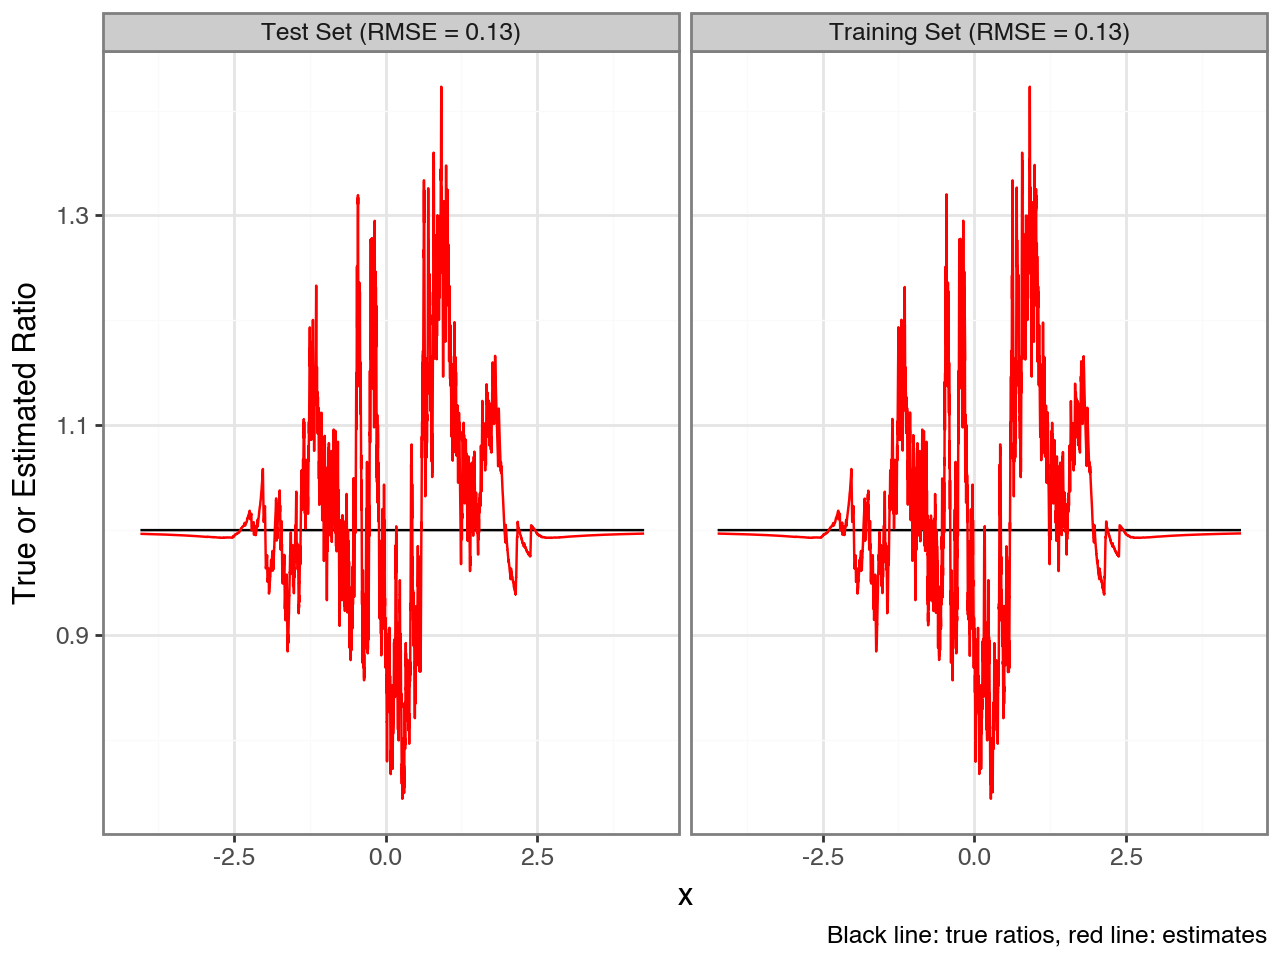

In [14]:
plot_1_run_results(df, rmse_train, rmse_test)

In [15]:
df, rmse_train, rmse_test = do_1_run(
    numer_class=st.norm,
    numer_params={"size": 10000},
    denom_class=st.norm,
    denom_params={"size": 10000},
    estimator_class=dre.KNNDensityRatioEstimator,
    estimator_init_args={"k_numer": 5000, "k_denom": 5000}
)

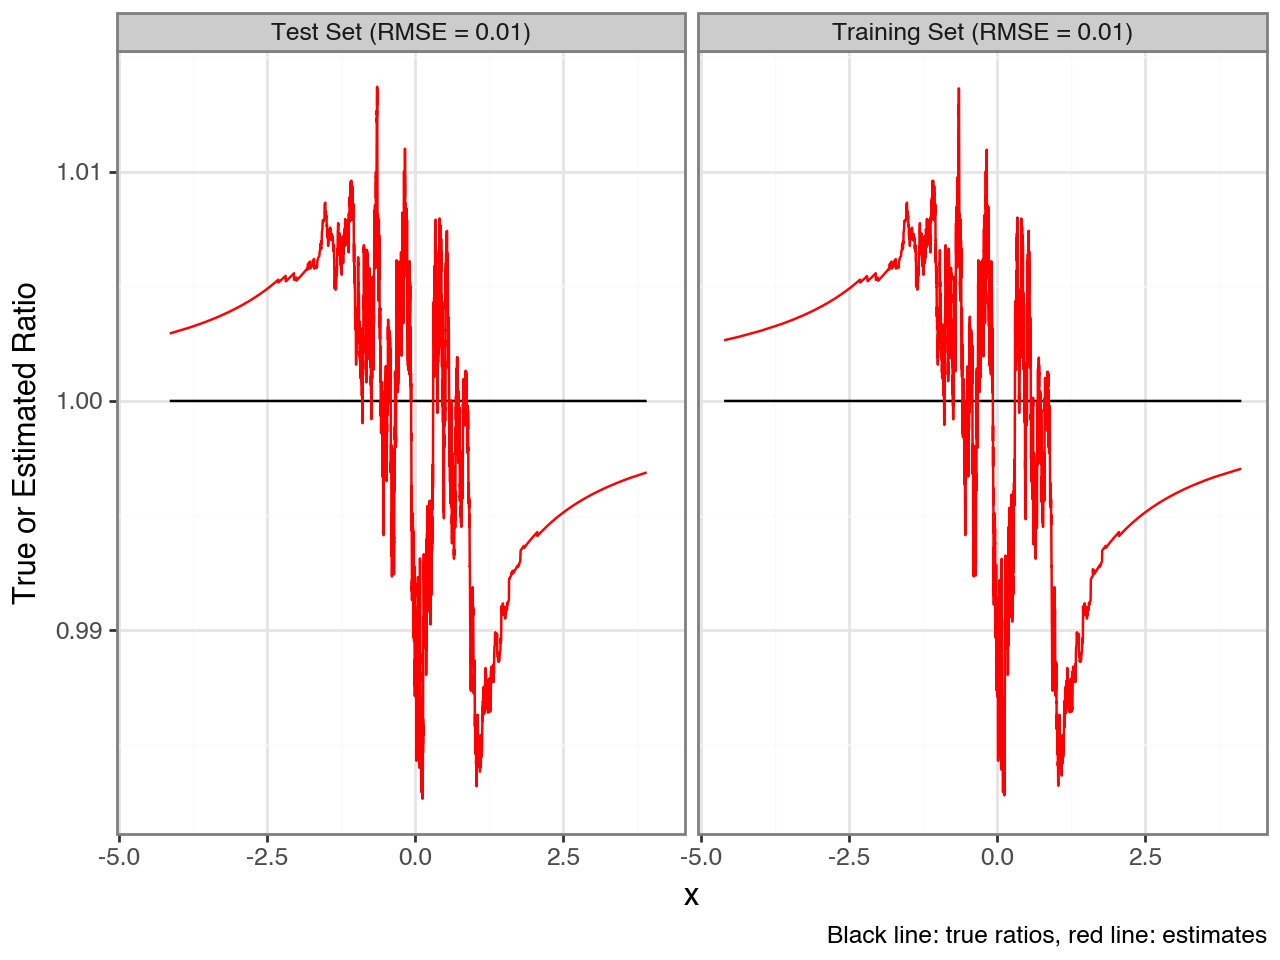

In [16]:
plot_1_run_results(df, rmse_train, rmse_test)

In [17]:
df, rmse_train, rmse_test = do_1_run(
    numer_class=st.norm,
    numer_params={"size": 10000},
    denom_class=st.norm,
    denom_params={"size": 10000},
    estimator_class=dre.KNNDensityRatioEstimator,
    estimator_init_args={"k_numer": 10000, "k_denom": 10000}
)

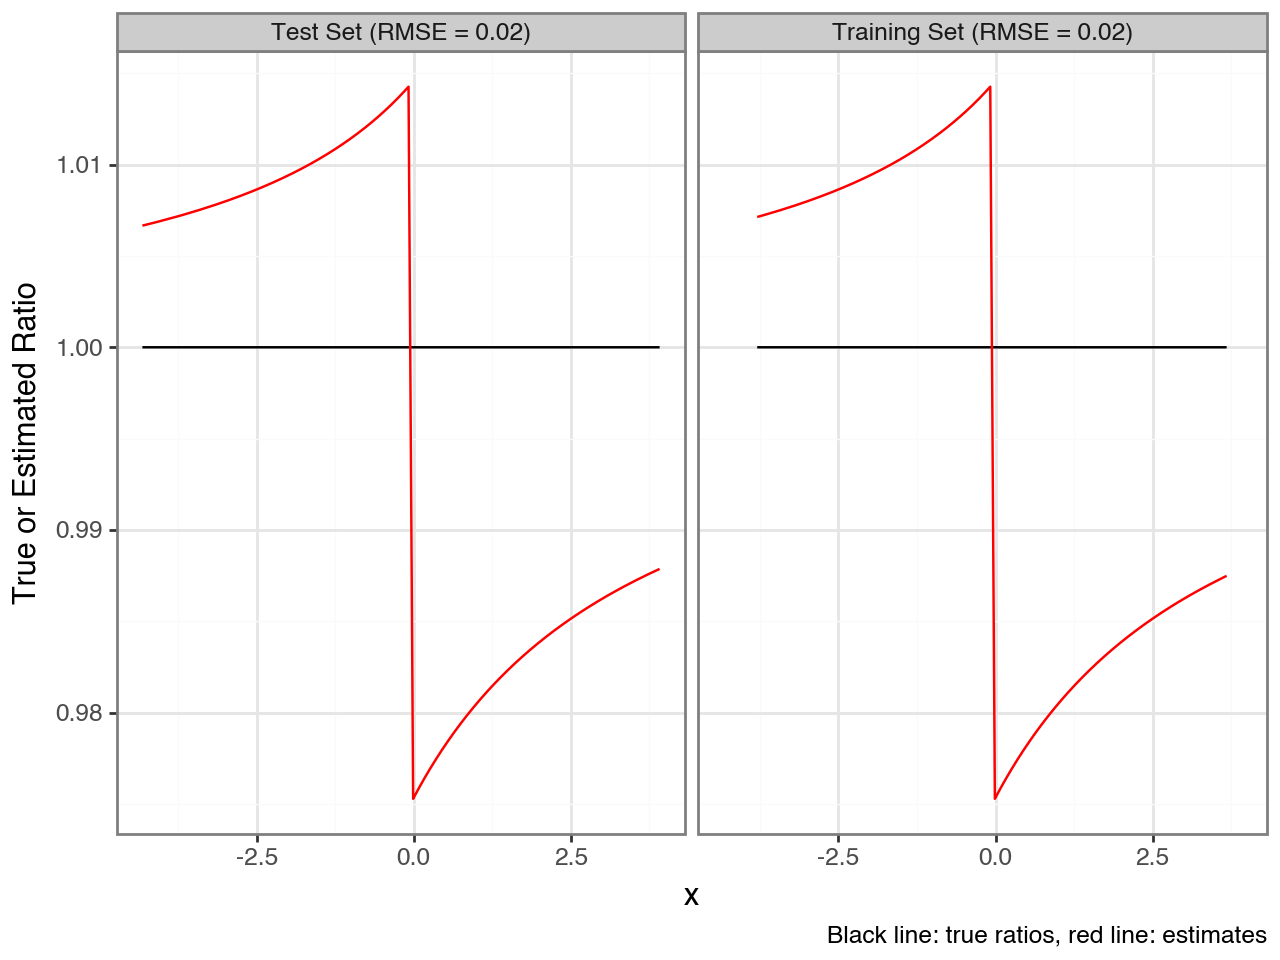

In [18]:
plot_1_run_results(df, rmse_train, rmse_test)

In [ ]:
rmses50 = simulate(
    num_runs=2,
    max_workers=8,
    numer_class=st.norm,
    numer_params={"size": 10000},
    denom_class=st.norm,
    denom_params={"size": 10000},
    estimator_class=dre.KNNDensityRatioEstimator,
    estimator_init_args={"k_numer": 50, "k_denom": 50}
)

In [ ]:
rmses500 = simulate(
    num_runs=2,
    max_workers=8,
    numer_class=st.norm,
    numer_params={"size": 10000},
    denom_class=st.norm,
    denom_params={"size": 10000},
    estimator_class=dre.KNNDensityRatioEstimator,
    estimator_init_args={"k_numer": 500, "k_denom": 500}
)

In [ ]:
rmses5000 = simulate(
    num_runs=2,
    max_workers=8,
    numer_class=st.norm,
    numer_params={"size": 10000},
    denom_class=st.norm,
    denom_params={"size": 10000},
    estimator_class=dre.KNNDensityRatioEstimator,
    estimator_init_args={"k_numer": 5000, "k_denom": 5000}
)

In [ ]:
rmses = pd.concat([rmses50, rmses500, rmses5000])
rmses.insert(0, "k", np.repeat(["50", "500", "5000"], 2))
(
    ggplot(data=rmses, mapping=aes(x="k", y="rmse_test", group="k"))
    + geom_boxplot()
    + theme_bw()
)

In [ ]:
df, rmse_train, rmse_test = do_1_run(
    numer_class=st.norm,
    numer_params={"loc": 1, "size": 10000},
    denom_class=st.norm,
    denom_params={"size": 10000},
    estimator_class=dre.KNNDensityRatioEstimator,
    estimator_init_args=(5000, 5000)
)
plot_1_run_results(df, rmse_train, rmse_test)

In [8]:
df, rmse_train, rmse_test = do_1_run(
    numer_class=st.norm,
    numer_params={"size": 10000},
    denom_class=st.norm,
    denom_params={"size": 10000},
    estimator_class=dre.RuLSIFDensityRatioEstimator,
    estimator_init_args={}
)

RuLSIF starting...
Searching for the optimal sigma and lambda...
sigma = 0.00100, lambda = 0.00100, score = -0.03135
sigma = 0.00100, lambda = 0.01000, score = -0.00578
sigma = 0.00100, lambda = 0.10000, score = -0.00063
sigma = 0.00100, lambda = 1.00000, score = -0.00006
sigma = 0.00100, lambda = 10.00000, score = -0.00001
sigma = 0.00100, lambda = 100.00000, score = -0.00000
sigma = 0.00100, lambda = 1000.00000, score = -0.00000
sigma = 0.00100, lambda = 10000.00000, score = -0.00000
sigma = 0.00100, lambda = 100000.00000, score = -0.00000
sigma = 0.00100, lambda = 1000000.00000, score = -0.00000
sigma = 0.00100, lambda = 10000000.00000, score = -0.00000
sigma = 0.00100, lambda = 100000000.00000, score = -0.00000
sigma = 0.00100, lambda = 1000000000.00000, score = -0.00000
sigma = 0.01000, lambda = 0.00100, score = -0.29481
sigma = 0.01000, lambda = 0.01000, score = -0.20981
sigma = 0.01000, lambda = 0.10000, score = -0.04896
sigma = 0.01000, lambda = 1.00000, score = -0.00565
sigma 

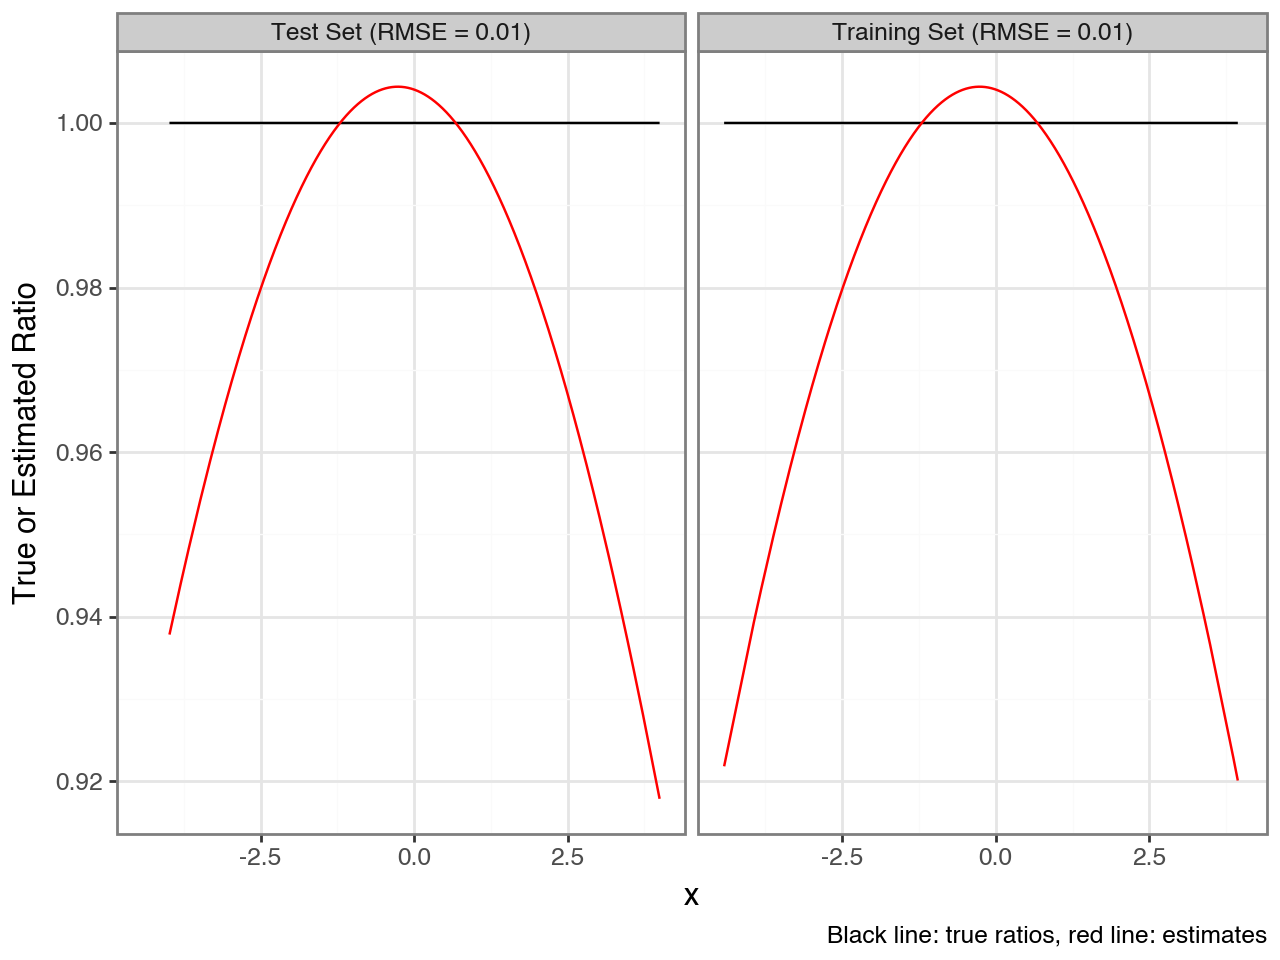

In [4]:
plot_1_run_results(df, rmse_train, rmse_test)

In [9]:
df, rmse_train, rmse_test = do_1_run(
    numer_class=st.norm,
    numer_params={"size": 10000},
    denom_class=st.norm,
    denom_params={"size": 10000},
    estimator_class=dre.RuLSIFDensityRatioEstimator,
    estimator_init_args={"sigma_range": [10, 100, 1000]}
)

RuLSIF starting...
Searching for the optimal sigma and lambda...
sigma = 10.00000, lambda = 0.00100, score = -0.49965
sigma = 10.00000, lambda = 0.01000, score = -0.49975
sigma = 10.00000, lambda = 0.10000, score = -0.49981
sigma = 10.00000, lambda = 1.00000, score = -0.49976
sigma = 10.00000, lambda = 10.00000, score = -0.49552
sigma = 10.00000, lambda = 100.00000, score = -0.37234
sigma = 10.00000, lambda = 1000.00000, score = -0.08525
sigma = 10.00000, lambda = 10000.00000, score = -0.00966
sigma = 10.00000, lambda = 100000.00000, score = -0.00098
sigma = 10.00000, lambda = 1000000.00000, score = -0.00010
sigma = 10.00000, lambda = 10000000.00000, score = -0.00001
sigma = 10.00000, lambda = 100000000.00000, score = -0.00000
sigma = 10.00000, lambda = 1000000000.00000, score = -0.00000
sigma = 100.00000, lambda = 0.00100, score = -0.50000
sigma = 100.00000, lambda = 0.01000, score = -0.50000
sigma = 100.00000, lambda = 0.10000, score = -0.50000
sigma = 100.00000, lambda = 1.00000, sc

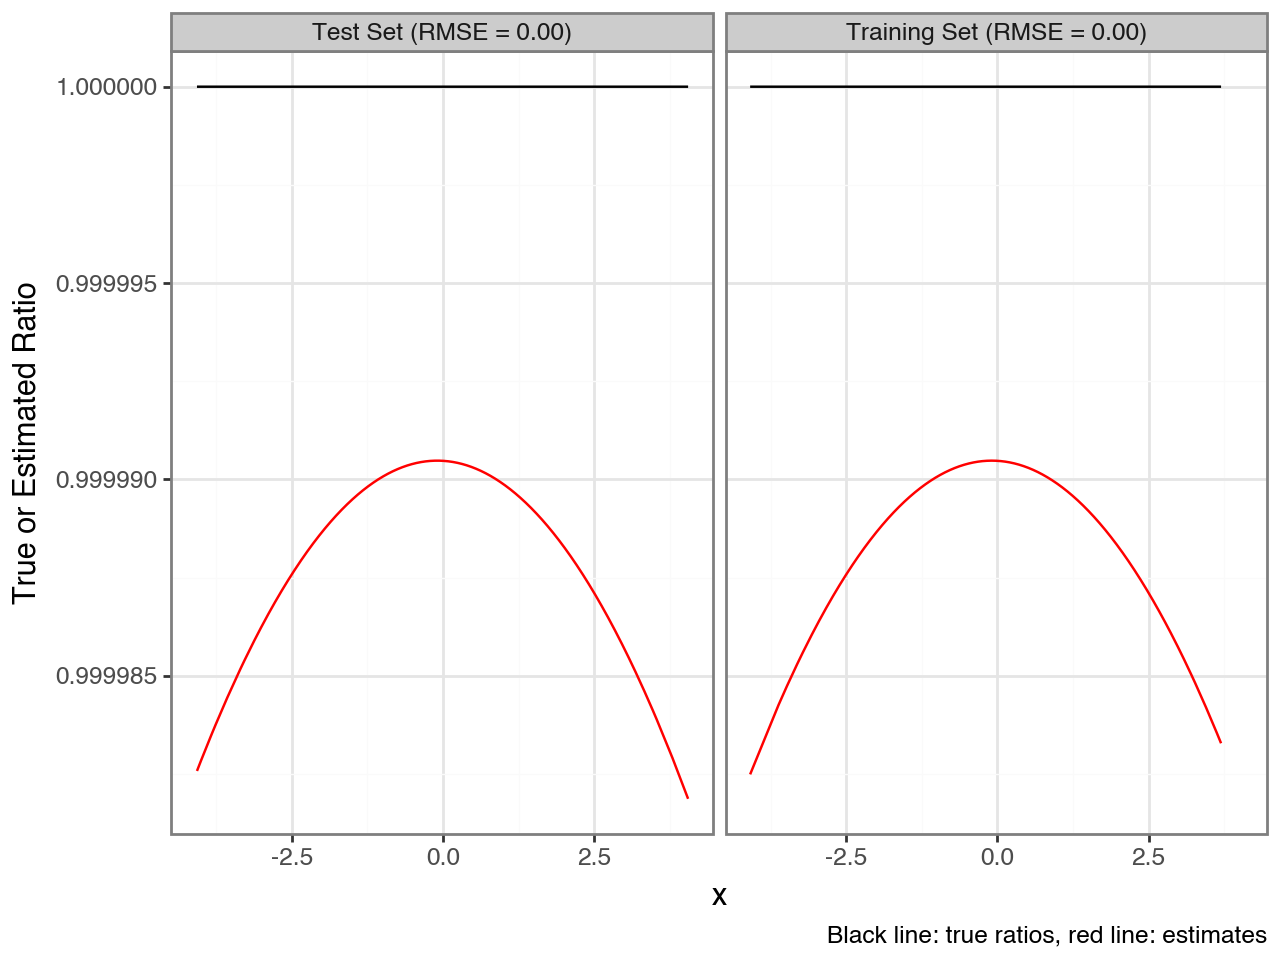

In [10]:
plot_1_run_results(df, rmse_train, rmse_test)